In [1]:
#Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import tweepy
import numpy as np
import time
from datetime import timedelta,datetime,date
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#Starting date for date/time converstion from UTC values
st = datetime(1899,12,31)

In [2]:
#Creating Color sets for data visualization:
c_bbc="#93ABD2"
c_cbs="#97C88A"
c_cnn="#FF84B5"
c_fox= "#E8A4A4"
c_nytimes= "#D9D9D9"
e_bbc="#25395A"
e_cbs="#2D4D24"
e_cnn="#99003E"
e_fox= "#862222"
e_nytimes= "#595959"
bbc_patch = mpatches.Patch(color=c_bbc, label="BBC")
cbs_patch = mpatches.Patch(color=c_cbs, label="CBS")
cnn_patch = mpatches.Patch(color=c_cnn, label="CNN")
fox_patch= mpatches.Patch(color=c_fox, label="FoxNews")
nytimes_patch= mpatches.Patch(color=c_nytimes, label="NY Times")
# Consolidating the colors and labels to a dictionary
news_o = ["BBC", "CBS", "CNN", "Fox", "NY Times"]
news_c=[c_bbc,c_cbs,c_cnn,c_fox,c_nytimes]
news_e=[e_bbc,e_cbs,e_cnn,e_fox,e_nytimes]
c_dict= dict(zip(news_o,news_c))
e_dict= dict(zip(news_o,news_e))


In [3]:
#configuration
from config import consumer_key, consumer_secret, access_token, access_token_secret
#establishing API authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [4]:
#Mapping news outlet Twitter handles to a non-twitter handle
news_dict=["@BBC", "@CBS", "@CNN", "@Fox", "@nytimes"]
outlet_map={news_dict[0]:"BBC",news_dict[1]:"CBS",news_dict[2]:"CNN",news_dict[3]:"Fox",news_dict[4]:"NY Times"}

In [5]:
news_handle= []
news_outlet=[]
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
tweet_date=[]
tweet_id=[]
user_id=[]
tweet_data=[]
news_count=[]

#Time to run query
start_time=time.time()
# Loop through 10 pages of tweets (total 100 tweets)
for news in news_dict:
    counter=1
    for x in range(1, 6):
    
        # Get all tweets from home feed
        public_tweets = api.user_timeline(news, page=x)

        # Loop through all tweets
        for tweet in public_tweets:

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            
            # Add each value to the appropriate list
            news_handle.append(news)
            news_outlet.append(outlet_map[news])
            compound_list.append(compound)
            positive_list.append(pos)
            negative_list.append(neg)
            neutral_list.append(neu)
            tweet_date.append(tweet["created_at"])
            tweet_data.append(tweet["text"])
            news_count.append(counter)
            
            counter=counter+1
print("API DATA FROM TWITTER COMPLETE. (elapsed time: %s seconds)" %(round(time.time()-start_time,3)))

API DATA FROM TWITTER COMPLETE. (elapsed time: 6.438 seconds)


In [6]:
#Construct all data from the individual data dictionaries into one dataframe for export and analysis
news_mood=pd.DataFrame(np.column_stack([news_outlet,news_handle,compound_list,positive_list,negative_list,neutral_list,tweet_date,tweet_data, news_count]),
                       columns=["outlet","handle","compound","positive","negative","neutral","date","tweet","tweet_count"])

In [7]:
#converting values from sentiment analysis from objects to floating point numbers
news_mood[["compound","positive","negative","neutral","tweet_count"]]=news_mood[["compound","positive","negative","neutral","tweet_count"]].apply(pd.to_numeric)

In [8]:
#saving output of API call to csv
news_mood.to_csv("NewsMood.csv")

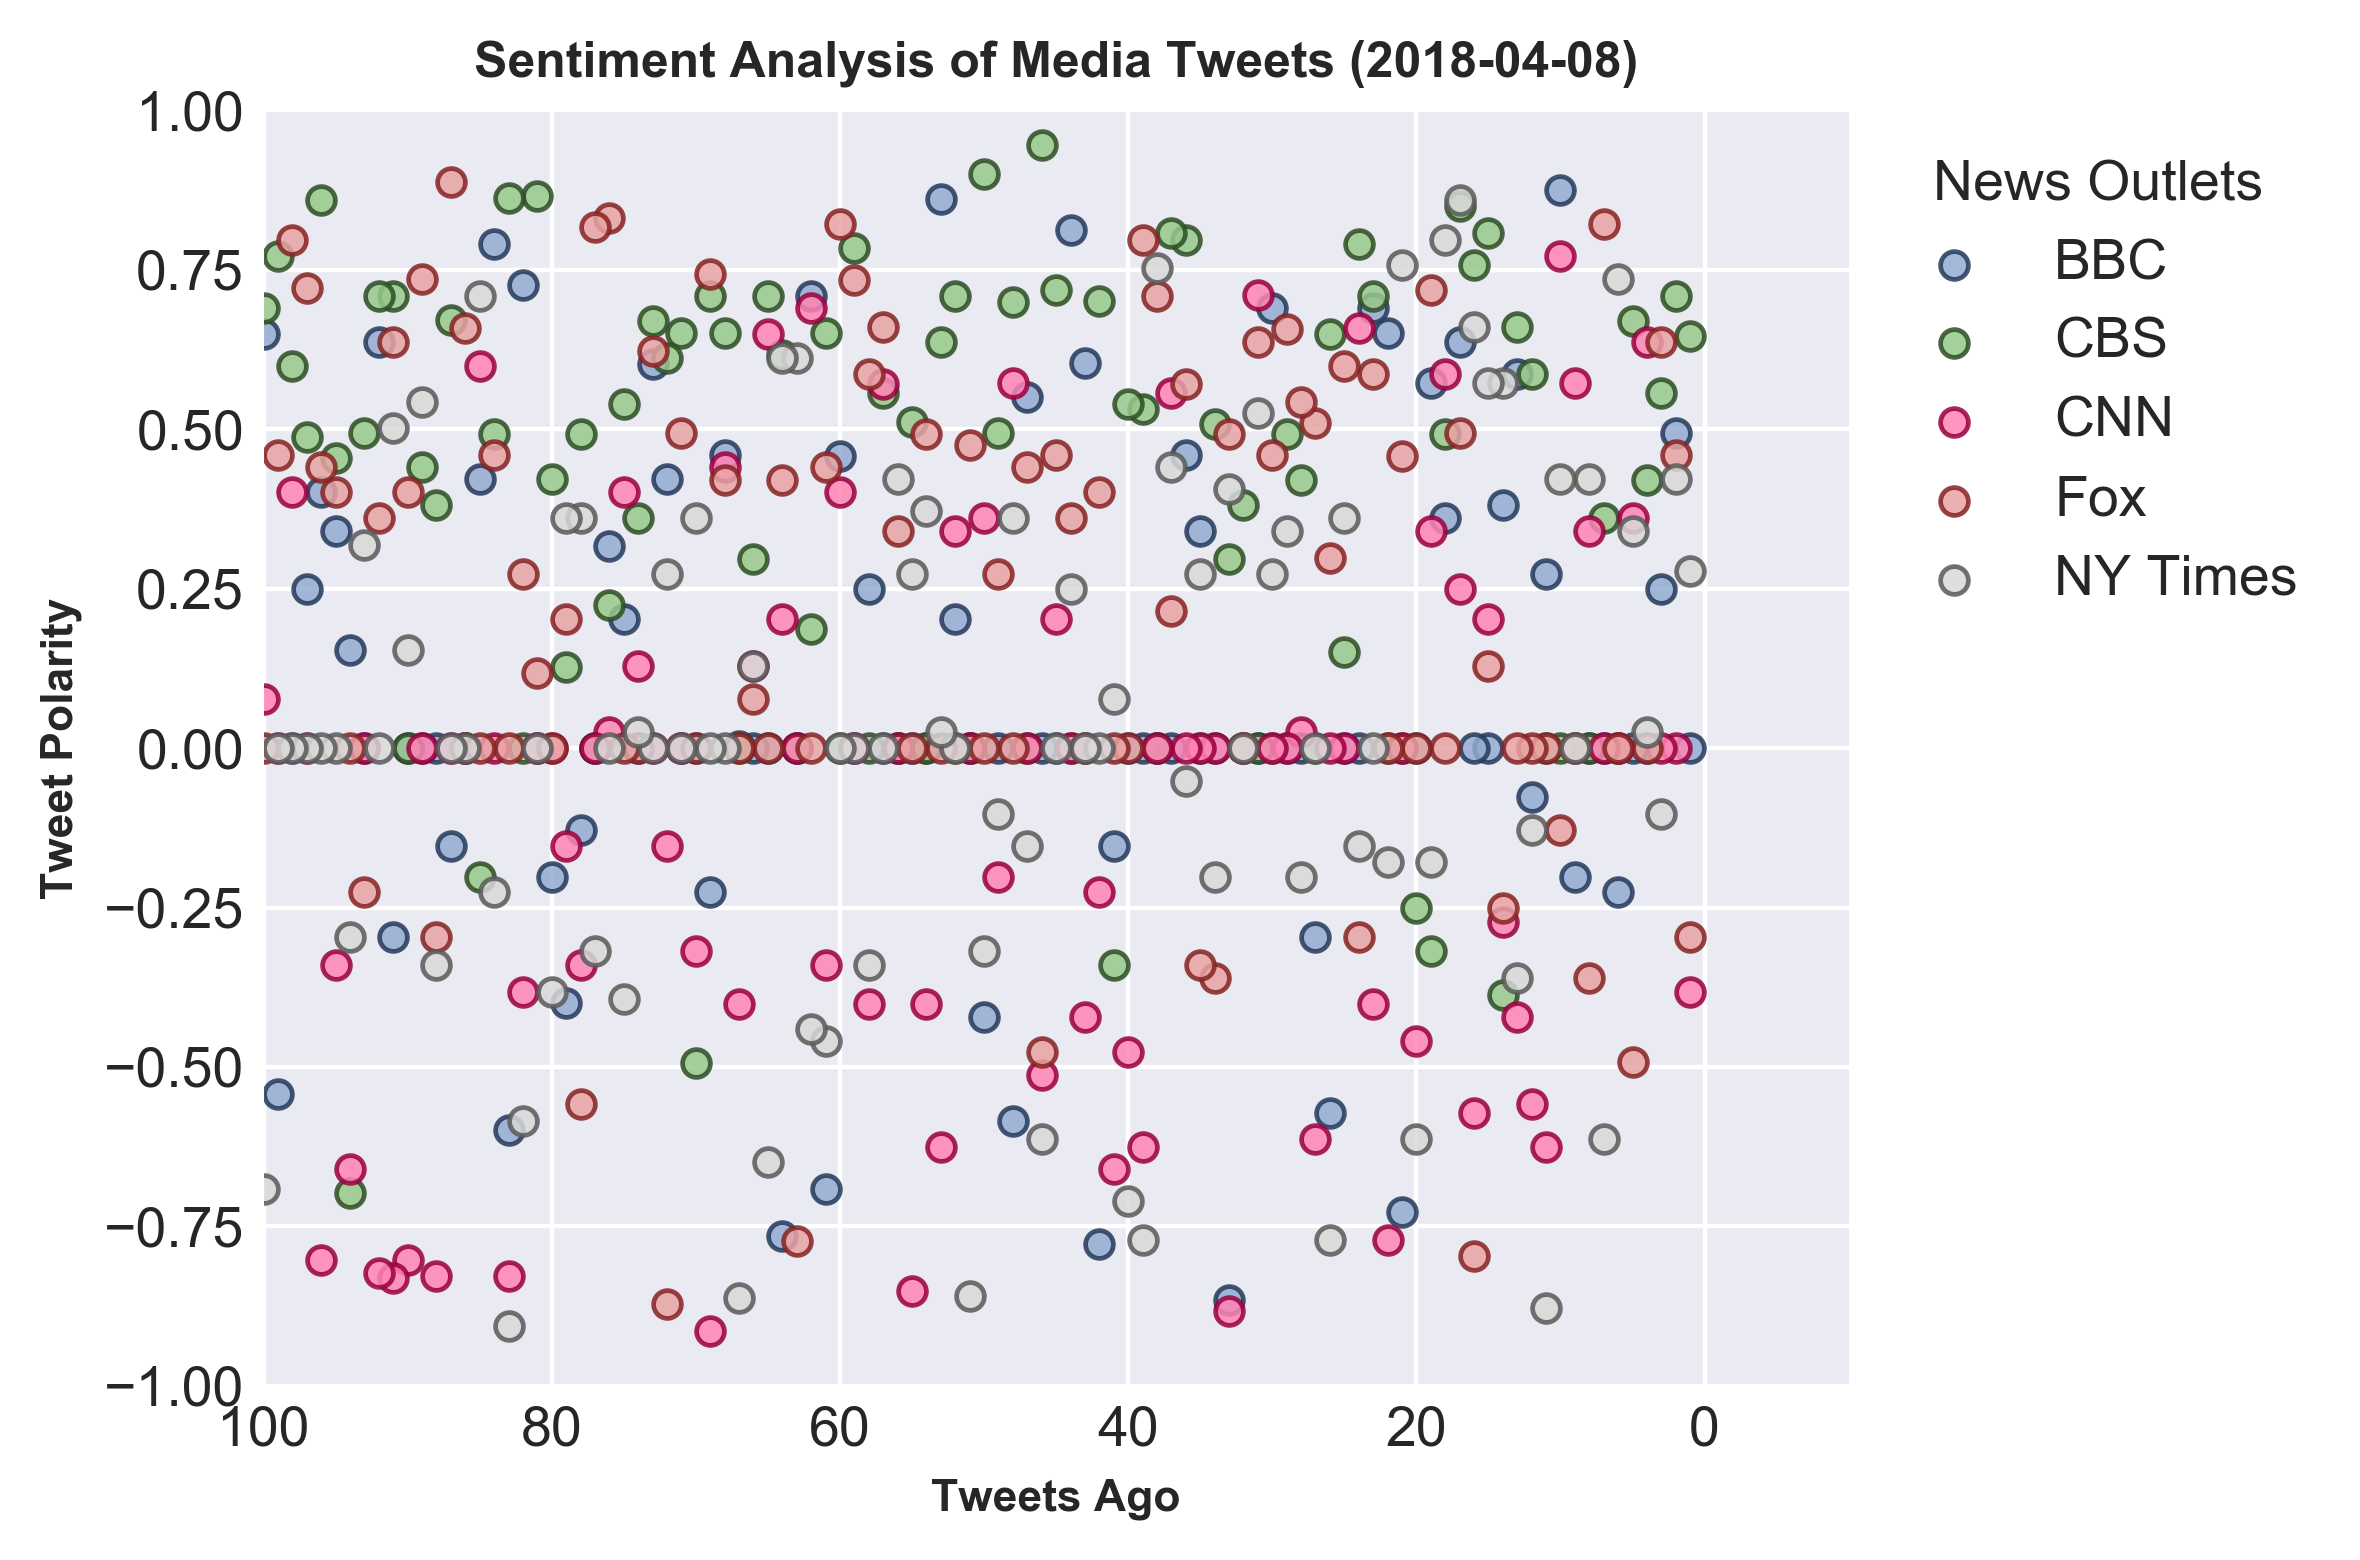

In [9]:
sns.set_style("darkgrid")
plt.figure(dpi=400)
plt.title("Sentiment Analysis of Media Tweets (%s)" % (time.strftime("%F")),fontweight="bold",size=9)
plt.xlabel("Tweets Ago", size=8,fontweight="bold")
plt.ylabel("Tweet Polarity", size=8,fontweight="bold")
plt.xlim(100,-10,-10)
plt.ylim(-1,1)
plt.grid(True)
for outlets in c_dict.keys():
    nm=news_mood[news_mood["outlet"]==outlets]
    mood_chart=plt.scatter(nm["tweet_count"], nm["compound"], s=25,label=outlets, color=c_dict[outlets], edgecolor=e_dict[outlets], linewidth=.85, alpha=.85)
    
plt.legend(bbox_to_anchor=(1,1),title="News Outlets")
plt.tight_layout()
mood_chart.figure.savefig("Sentiment_analysis.png")

In [10]:
overall_news_mood=news_mood.groupby("outlet")["compound"].mean()
overall_news_mood

outlet
BBC         0.091746
CBS         0.369603
CNN        -0.080716
Fox         0.227275
NY Times    0.021295
Name: compound, dtype: float64

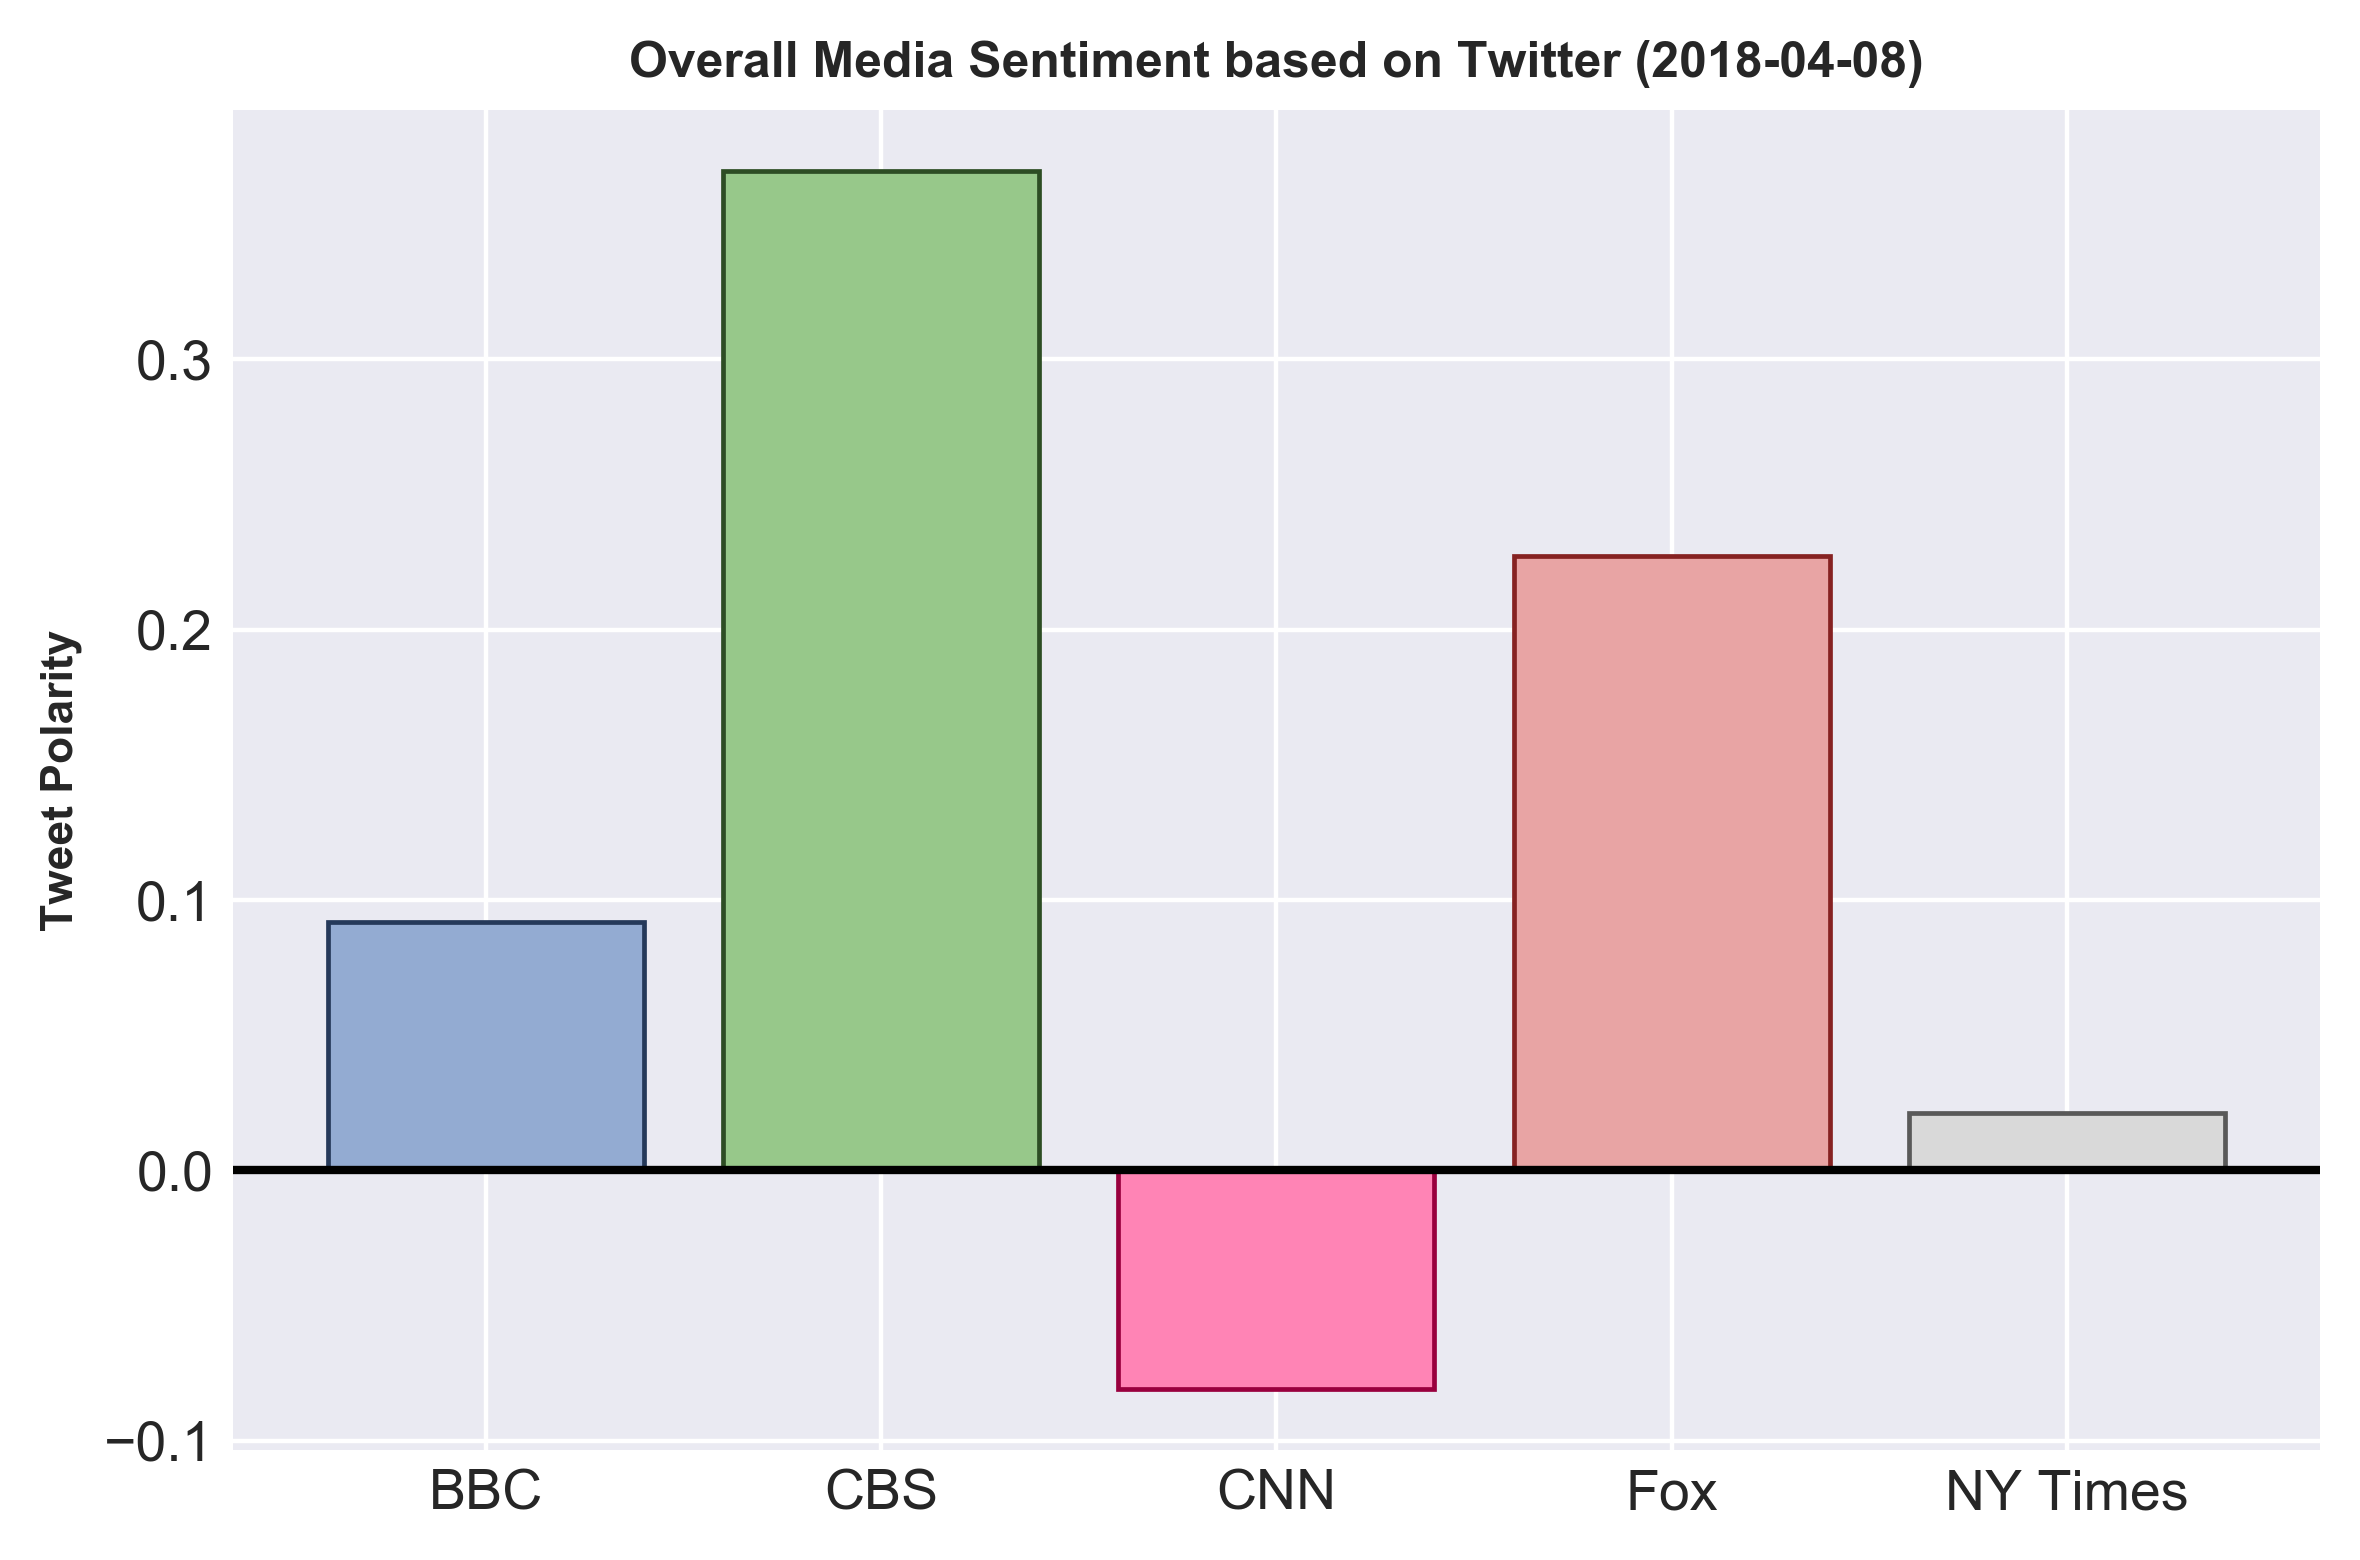

In [11]:
sns.set_style("darkgrid")
plt.figure(dpi=400)
plt.title("Overall Media Sentiment based on Twitter (%s)" % (time.strftime("%F")),fontweight="bold",size=9)
plt.ylabel("Tweet Polarity", size=8,fontweight="bold")
plt.grid(True)
bar_chart=plt.bar(news_o,overall_news_mood, color=news_c, edgecolor=news_e, linewidth=.85)
x_locations = [value for value in np.arange(6)]#tick locations
plt.axhline(y=0, color = "#000000")
plt.tight_layout()
plt.savefig("Overall_Media_Sentiment_analysis.png")